## Preliminaries

In [2]:
import numpy as np
import torch
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff

In [3]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simulator

In [4]:
from HH_helper_functions import syn_current

I, t_on, t_off, dt, t, A_soma = syn_current()

In [5]:
from HH_helper_functions import HHsimulator

In [6]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [7]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])

num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

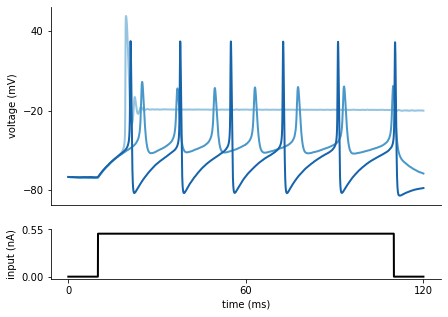

In [8]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [9]:
from HH_helper_functions import calculate_summary_statistics

In [10]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [11]:
true_params = np.array([50., 5.])
labels_params = [r'$g_{Na}$', r'$g_{K}$']
observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

In [12]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Distance functions

In [13]:
def euclidean(x,y):
    return np.linalg.norm(x-y)

def simulation_wrapper_euclidean(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    data = observation_trace['data']
    obs = run_HH_model(params)['data']
    summstats = euclidean(data,obs)
    return torch.as_tensor([summstats])

In [14]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


In [15]:
def simulation_wrapper_hausdorff(params, reverse=False):
    data = observation_trace
    obs = run_HH_model(params)
    summstats = hausdorff_dist(data,obs, reverse)
    return torch.as_tensor([summstats[0]])

## Create categorical distributions from proposals

In [ ]:
class Empirical_Fix(Empirical):
    def __init__(self, samples, log_weights, validate_args=None):
        super().__init__(samples, log_weights, validate_args=validate_args)

    def log_prob(self, value):
        sample_shape = super().sample().shape
        sample_shape_len = len(sample_shape)
        if value.shape == sample_shape:
            return super().log_prob(value)

        if sample_shape_len:
            assert (value.shape[-sample_shape_len:]==sample_shape), "The value needs to consist of samples from the empricial distribution"
            batch_shape = value.shape[:-sample_shape_len]
        else:
            batch_shape = value.shape
        num_samples = batch_shape.numel()

        value_reshape = value.reshape((num_samples,)+sample_shape)
        log_probs = []
        
        for i in value_reshape:
            log_probs.append(super().log_prob(i))
            
        log_probs_tensor= torch.tensor(log_probs)
        return log_probs_tensor.reshape(batch_shape)

In [169]:
def effective_sample_size(w):
    """Effective sample size of weights

    `w` is a 1-dimensional tensor of weights (normalised or unnormalised)"""
    sumw = torch.sum(w)
    if sumw == 0:
        return 0.

    return (sumw ** 2.0) / torch.sum(w ** 2.0)

def get_alternate_weights(sqd, old_weights, eps):
    """Return weights appropriate to another `epsilon` value"""
    # Interpretable version of the generic reweighting code:
    # w = old_weights
    # d = torch.sqrt(sqd)
    # w /= torch.exp(-0.5*(d / old_eps)**2.)
    # w *= torch.exp(-0.5*(d / new_eps)**2.)
    # w /= sum(w)

    w = old_weights.detach().clone()
    if eps == 0:
        # Remove existing distance-based weight contribution
        # Replace with indicator function weight contribution
        w = torch.where(
            sqd==0.,
            w,
            torch.zeros_like(w)
        )
    else:
        # An efficient way to do the generic case
        a = - 0.5 * eps**-2.
        w *= torch.exp(sqd*a)

    sumw = torch.sum(w)
    if sumw > 0.:
        w /= sumw
    return w


def find_eps(sqd, old_weights, target_ess, upper, bisection_its=50):
        """Return epsilon value <= `upper` giving ess matching `target_ess` as closely as possible

        Bisection search is performed using `bisection_its` iterations
        """
        w = get_alternate_weights(sqd, old_weights, upper)
        ess = effective_sample_size(w)
        if ess < target_ess:
            return upper

        lower = 0.
        for i in range(bisection_its):
            eps_guess = (lower + upper) / 2.
            w = get_alternate_weights(sqd, old_weights, eps_guess)
            ess = effective_sample_size(w)
            if ess > target_ess:
                upper = eps_guess
            else:
                lower = eps_guess

        # Consider returning eps=0 if it's still an endpoint
        if lower == 0.:
            w = get_alternate_weights(sqd, old_weights, 0.)
            ess = effective_sample_size(w)
            if ess > target_ess:
                return 0.

        # Be conservative by returning upper end of remaining range
        return upper
        
def to_empirical(simulator, distribution, distance_function, num_simulations, num_workers, obs, old_epsilon=np.inf):
    theta, x = simulate_for_sbi(simulator, distribution, 
    num_simulations=num_simulations, num_workers=num_workers)
    distances = Parallel(n_jobs=num_workers, verbose=10)(delayed(distance_function)(data, obs) for data in x)
    sqd = torch.tensor(distances)**2
    old_log_prob = distribution.log_prob(theta)
    old_weights =np.exp(old_log_prob)/np.exp(old_log_prob).sum()
    if old_epsilon == np.inf:
        upper = torch.max(sqd).item()
    else:
        upper = old_epsilon
    epsilon = find_eps(sqd, old_weights, target_ess=num_simulations/10, upper=upper)
    log_prob = old_log_prob - 0.5*sqd/epsilon**2
    return epsilon, Empirical_Fix(theta, log_prob)

## Build posterior

In [170]:
obs = observation_trace['data']
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)
epsilon, new_prior = to_empirical(simulator, prior, euclidean, 100, 7, obs, old_epsilon=np.inf)
simulator, new_prior = prepare_for_sbi(simulation_wrapper_euclidean, new_prior)
inference = SNPE(prior = prior)
proposal = new_prior
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500, num_workers=7)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train() # Will this work with empirical prop
posterior = inference.build_posterior(density_estimator)


Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Batch computation too fast (0.0095s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Batch computation too fast (0.0481s.) Setting batch_size=4.
[Parallel(n_jobs=7)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.0497s.) Setting batch_size=8.
[Parallel(n_jobs=7)]: Done  98 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.2s finished


Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

/home/sragy/anaconda3/lib/python3.8/site-packages/sbi/inference/snpe/snpe_base.py:525: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(


AttributeError: 'Empirical_Fix' object has no attribute 'posterior_estimator'

In [ ]:
obs = observation_trace['data']
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)
epsilon, new_prior = to_empirical(simulator, prior, euclidean, 1000, 7, obs, old_epsilon=np.inf)
inference = SNPE(prior = prior)

num_rounds = 5
posteriors = []
proposal = new_prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

## Roughs

In [61]:
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)

In [28]:
theta, x = simulate_for_sbi(simulator, prior, 
    num_simulations=100, num_workers=7)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
obs = observation_trace['data']
distances = torch.tensor([euclidean(data, obs) for data in x])
sqd = distances**2

In [36]:
np.exp(prior.log_prob(theta))

tensor([0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008])

In [55]:
epsilon = max(sqd)
raw_log_prob = prior.log_prob(theta) - 0.5*sqd/epsilon**2

In [56]:
np.exp(raw_log_prob)

tensor(0.0839, dtype=torch.float64)

In [58]:
dict(enumerate(theta))

{0: tensor([64.1508,  6.3358]),
 1: tensor([ 4.0479, 10.1101]),
 2: tensor([26.3836,  7.2157]),
 3: tensor([45.6671,  3.5976]),
 4: tensor([18.0346, 11.9792]),
 5: tensor([39.9350,  3.7959]),
 6: tensor([7.3710, 9.3698]),
 7: tensor([79.0912,  0.8932]),
 8: tensor([23.1577,  9.8465]),
 9: tensor([13.9234, 12.2477]),
 10: tensor([23.1564,  8.8900]),
 11: tensor([30.4379,  7.7535]),
 12: tensor([8.8686, 9.0499]),
 13: tensor([27.8244,  8.8104]),
 14: tensor([44.3315, 14.0887]),
 15: tensor([73.8378, 14.7340]),
 16: tensor([20.0560,  2.0684]),
 17: tensor([37.7324,  9.3064]),
 18: tensor([76.5452,  1.9988]),
 19: tensor([40.0166,  3.4142]),
 20: tensor([6.5483, 3.0816]),
 21: tensor([63.1950,  6.4334]),
 22: tensor([30.4041,  0.0510]),
 23: tensor([34.6957,  4.3169]),
 24: tensor([0.7388, 5.8235]),
 25: tensor([43.4647, 10.4007]),
 26: tensor([71.0823,  8.7033]),
 27: tensor([65.5067,  7.0060]),
 28: tensor([46.0016,  3.8602]),
 29: tensor([64.8196,  3.5222]),
 30: tensor([11.1141,  9.566

In [16]:
thetas_test = torch.tensor([0.1,0.2,0.3,0.4])
log_prob_test = torch.log(torch.tensor([1,1,1,1]))

In [96]:
test_categorical = CategoricalThetas(thetas = thetas_test, logits = log_prob_test)

In [97]:
test_categorical.log_prob(torch.tensor(0.1))

tensor(0.1000)
{tensor(0.1000): 0, tensor(0.2000): 1, tensor(0.3000): 2, tensor(0.4000): 3}


KeyError: tensor(0.1000)

In [100]:
test_categorical.dict_reverse.keys()

dict_keys([tensor(0.1000), tensor(0.2000), tensor(0.3000), tensor(0.4000)])

In [73]:
test.shape == torch.Size()

False

In [117]:
embedding = torch.nn.Embedding(10,1)

In [121]:
embedding(torch.LongTensor([[1,2,4,5],[4,3,2,9]]))

tensor([[[-0.1065],
         [ 1.1853],
         [ 0.7896],
         [ 0.5211]],

        [[ 0.7896],
         [ 0.6781],
         [ 1.1853],
         [ 0.1682]]], grad_fn=<EmbeddingBackward0>)

In [109]:
torch.LongTensor([[1,2,4,5],[4,3,2,9]])

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [17]:
from pyro.distributions.empirical import Empirical

In [18]:
empirical_test = Empirical(thetas_test, log_prob_test)

In [132]:
empirical_test.log_prob(empirical_test.sample())

tensor(-1.3863)

In [20]:
empirical_test.sample((2,))

tensor([0.3000, 0.1000])

In [22]:
empirical_test.log_prob(empirical_test.sample((2,)))

ValueError: ``value.shape`` must be torch.Size([])

In [25]:
prior.log_prob(prior.sample((3,)))

tensor([-7.0838, -7.0838, -7.0838])

In [27]:
empirical_test.sample((3,))

tensor([0.1000, 0.1000, 0.4000])

In [153]:
class Empirical_Fix(Empirical):
    def __init__(self, samples, log_weights, validate_args=None):
        super().__init__(samples, log_weights, validate_args=validate_args)

    def log_prob(self, value):
        sample_shape = super().sample().shape
        sample_shape_len = len(sample_shape)
        if value.shape == sample_shape:
            return super().log_prob(value)

        if sample_shape_len:
            assert (value.shape[-sample_shape_len:]==sample_shape), "The value needs to consist of samples from the empricial distribution"
            batch_shape = value.shape[:-sample_shape_len]
        else:
            batch_shape = value.shape
        num_samples = batch_shape.numel()

        value_reshape = value.reshape((num_samples,)+sample_shape)
        log_probs = []
        
        for i in value_reshape:
            log_probs.append(super().log_prob(i))
            
        log_probs_tensor= torch.tensor(log_probs)
        return log_probs_tensor.reshape(batch_shape)

        
        

In [154]:
test=Empirical_Fix(thetas_test,log_prob_test)

In [157]:
test.log_prob(test.sample((4,2)))

tensor([[-1.3863, -1.3863],
        [-1.3863, -1.3863],
        [-1.3863, -1.3863],
        [-1.3863, -1.3863]])

In [166]:
test2_samples = prior.sample((4,))
test2_log_probs =prior.log_prob(test2_samples)
test2_emp = Empirical_Fix(test2_samples,test2_log_probs)

In [168]:
test2_emp.log_prob(test2_emp.sample((4,2)))

tensor([[-1.3863, -1.3863],
        [-1.3863, -1.3863],
        [-1.3863, -1.3863],
        [-1.3863, -1.3863]])

In [36]:
# Consider a tensor where each element is a sample

torch.tensor([[prior.sample(),prior.sample()],[prior.sample(),prior.sample()]])

ValueError: only one element tensors can be converted to Python scalars

In [59]:
to_test = torch.tensor([[prior.sample().numpy(),prior.sample().numpy()],[prior.sample().numpy(),prior.sample().numpy()]])

In [60]:
to_test.shape

torch.Size([2, 2, 2])

In [50]:
to_test.reshape(4,2)

tensor([[75.7657,  6.2247],
        [13.9136,  4.1647],
        [28.7255,  3.9021],
        [16.4916,  1.2553]])

In [51]:
to_test = prior.sample((4,1))

In [58]:
prior.sample((2,2)).shape

torch.Size([2, 2, 2])

In [62]:
theta, x = simulate_for_sbi(simulator, prior, 
    num_simulations=100, num_workers=7)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
len(prior.sample().shape)

1

In [71]:
prior.log_prob(prior.sample((6,3,2))).shape

torch.Size([6, 3, 2])

In [75]:
prior.sample((4,1)).reshape((4,2))

tensor([[ 9.1589, 11.3724],
        [36.7130,  2.7531],
        [53.1038,  1.7868],
        [77.2809,  8.7662]])

In [80]:
prior.sample((4,2,3)).shape[:-1].numel()

24

In [82]:
test = prior.sample((4,2,3))

In [83]:
test.reshape((24,2))

tensor([[33.7681,  1.2995],
        [53.6290,  4.7060],
        [71.9419, 14.7308],
        [ 6.9624,  4.8853],
        [20.4978, 10.9546],
        [60.1660, 11.8774],
        [18.5928,  3.7703],
        [30.3174,  4.1249],
        [36.0342,  8.8813],
        [ 0.9555,  5.9921],
        [75.0539, 14.2423],
        [24.6465, 14.2595],
        [42.0809, 14.8762],
        [40.1458,  2.9079],
        [ 6.9023,  5.7981],
        [39.8919, 13.6442],
        [ 0.7433, 14.3168],
        [57.2902, 14.2004],
        [48.2973,  2.1598],
        [39.2497,  9.4978],
        [14.1473,  7.3808],
        [21.7547,  1.7464],
        [23.2389, 13.0466],
        [34.5696,  7.8826]])

In [84]:
test

tensor([[[[33.7681,  1.2995],
          [53.6290,  4.7060],
          [71.9419, 14.7308]],

         [[ 6.9624,  4.8853],
          [20.4978, 10.9546],
          [60.1660, 11.8774]]],


        [[[18.5928,  3.7703],
          [30.3174,  4.1249],
          [36.0342,  8.8813]],

         [[ 0.9555,  5.9921],
          [75.0539, 14.2423],
          [24.6465, 14.2595]]],


        [[[42.0809, 14.8762],
          [40.1458,  2.9079],
          [ 6.9023,  5.7981]],

         [[39.8919, 13.6442],
          [ 0.7433, 14.3168],
          [57.2902, 14.2004]]],


        [[[48.2973,  2.1598],
          [39.2497,  9.4978],
          [14.1473,  7.3808]],

         [[21.7547,  1.7464],
          [23.2389, 13.0466],
          [34.5696,  7.8826]]]])

In [92]:
sample_shape=prior.sample().shape

In [88]:
(8,)+sample_shape

(8, 2)

In [94]:
prior.sample((4,1)).dim()

3

In [112]:
class Empirical_Fix2(Empirical):
    def __init__(self, samples, log_weights, validate_args=None):
        super().__init__(samples, log_weights, validate_args=validate_args)

    def log_prob(self, value):
        """
        Returns the log of the probability mass function evaluated at ``value``.
        Note that this currently only supports scoring values with empty
        ``sample_shape``.

        :param torch.Tensor value: scalar or tensor value to be scored.
        """
        if self._validate_args:
            if value.shape != self.batch_shape + self.event_shape:
                raise ValueError(
                    "``value.shape`` must be {}".format(
                        self.batch_shape + self.event_shape
                    )
                )
        if self.batch_shape:
            value = value.unsqueeze(self._aggregation_dim)
        selection_mask = self._samples.eq(value)
        print(selection_mask) # Doesn't work because values must be in right place.
        # Get a mask for all entries in the ``weights`` tensor
        # that correspond to ``value``.
        for _ in range(len(self.event_shape)):
            selection_mask = selection_mask.min(dim=-1)[0]
        selection_mask = selection_mask.type(self._categorical.probs.type())
        print(selection_mask)
        return (self._categorical.probs * selection_mask).log()
        

In [130]:
test=Empirical_Fix2(thetas_test,log_prob_test)

In [135]:
test.log_prob(test.sample((4,1)))

AssertionError: The value needs to consist of samples from the empricial distribution

In [149]:
[4,1,3][:-1]

[4, 1]